In [1]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import itertools
from scipy.signal import convolve2d, correlate2d

In [2]:
img = cv2.imread('./source/100-4.jpg')
template = cv2.imread('./template/100-Template.jpg')

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(template)

In [ ]:
def conv(x, y):
    # pad
    pad = np.array(y.shape) // 2
    padded_x = np.ones([x.shape[0] + pad[0]*2, x.shape[1] + pad[1]*2]) * 0
    padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = x
    
    # conv windows
    view_shape = tuple(np.subtract(padded_x.shape, y.shape) + 1) + y.shape
    strides = padded_x.strides + padded_x.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

    # einsum method
    y = np.flipud(np.fliplr(y))

    m = np.einsum('ij,klij->kl', y, sub_matrices)

    return m

def CrossCorrelation(x, y):
    # pad
    pad = np.array(y.shape) // 2
    padded_x = np.ones([x.shape[0] + pad[0]*2, x.shape[1] + pad[1]*2]) * 0
    padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = x
    
    # conv windows
    view_shape = tuple(np.subtract(padded_x.shape, y.shape) + 1) + y.shape
    strides = padded_x.strides + padded_x.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

    # einsum method
    m = np.einsum('ij,klij->kl', y, sub_matrices)

    return m

In [3]:
img = img[:, :, 2]*0.299 + img[:, :, 1]*0.587 + img[:, :, 0]*0.114
img = img.astype(np.uint8)

template = template[:, :, 2]*0.299 + template[:, :, 1]*0.587 + template[:, :, 0]*0.114
template = template.astype(np.uint8)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(template, cmap='gray')

In [ ]:
dst = cv2.cornerHarris(template, 2, 3, 0.04)
# dst = cv2.Canny(template, 200, 250)

a = (dst - dst.min()) / (dst.max() - dst.min()) * 255
a = np.abs(a)

featureMap = a < 140

b = np.zeros(a.shape)
b[featureMap] = 1

plt.figure(figsize=(10, 10))
plt.imshow(b, cmap='gray')

In [ ]:
np.sum(featureMap)

In [ ]:
Sx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]])
Sy = np.array([[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]])

In [ ]:
Gx = convolve2d(template, Sx, mode='same', boundary='fill', fillvalue=0)
Gy = convolve2d(template, Sy, mode='same', boundary='fill', fillvalue=0)

In [ ]:
d = np.empty([*template.shape, 2])
d[:, :, 0] = Gx
d[:, :, 1] = Gy

In [ ]:
p = np.empty([*template.shape, 2], dtype=np.int32)
p_center = np.array(template.shape)//2
for x, y in itertools.product(range(template.shape[0]), range(template.shape[1])):
    p[x, y, :] = [x, y]
p = p - p_center

In [ ]:
e = np.empty([*img.shape, 2])
e[:, :, 0] = convolve2d(img, Sx, mode='same', boundary='fill', fillvalue=0)
e[:, :, 1] = convolve2d(img, Sy, mode='same', boundary='fill', fillvalue=0)

In [ ]:
d = d[featureMap]
p = p[featureMap]

In [ ]:
res = np.zeros(img.shape)
for qx, qy in itertools.product(range(-p[:, 0].min(), img.shape[0] - p[:, 0].max()), range(-p[:, 1].min(), img.shape[1] - p[:, 1].max())):
    center = p + [qx, qy]
    e_part = e[center[:, 0], center[:, 1]]
    res[qx, qy] = np.mean(np.nan_to_num(np.sum(e_part * d, axis=-1) / np.sqrt((d[:, 0]**2 + d[:, 1]**2) * (e_part[:, 0]**2 + e_part[:, 1]**2))))

In [ ]:
w, h = template.shape[::-1]
img_res = img.copy()

threshold = 0.6
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_res, (pt[0] - w//2, pt[1] - h//2), (pt[0] + w//2, pt[1] + h//2), (0,0,255), 2)
    
plt.figure(figsize=(20, 10))
plt.imshow(img_res, cmap='gray')

# write into function

In [ ]:
def matching(simg, stempl):
    dst = cv2.Canny(stempl, 200, 1)
    featureMap = dst > 0

    # dst = cv2.cornerHarris(stempl, 2, 3, 0.04)
    # a = (dst - dst.min()) / (dst.max() - dst.min()) * 255
    # a = np.abs(a)
    # featureMap = a < 140


    # pad
    pad = np.array(stempl.shape) // 2
    padded_x = np.ones([simg.shape[0] + pad[0]*2, simg.shape[1] + pad[1]*2]) * 0
    padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = simg

    simg = padded_x
    
    # sobel 
    Sx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]])
    Sy = np.array([[1, 2, 1],
                [0, 0, 0],
                [-1, -2, -1]])

    # template gradient
    d = np.empty([*stempl.shape, 2])
    d[:, :, 0] = convolve2d(stempl, Sx, mode='same', boundary='fill', fillvalue=0)
    d[:, :, 1] = convolve2d(stempl, Sy, mode='same', boundary='fill', fillvalue=0)

    # feature position
    p = np.empty([*stempl.shape, 2], dtype=np.int32)    
    for x, y in itertools.product(range(stempl.shape[0]), range(stempl.shape[1])):
        p[x, y, :] = [x, y]
    
    # image grsdient
    e = np.empty([*simg.shape, 2])
    e[:, :, 0] = convolve2d(simg, Sx, mode='same', boundary='fill', fillvalue=0)
    e[:, :, 1] = convolve2d(simg, Sy, mode='same', boundary='fill', fillvalue=0)

    d = d[featureMap]
    p = p[featureMap]

    res = np.zeros(simg.shape)
    for qx, qy in itertools.product(range(simg.shape[0] - stempl.shape[0]), range(simg.shape[1] - stempl.shape[1])):
        
        ps = p + [qx, qy]
        e_part = e[ps[:, 0], ps[:, 1]]
        res[qx, qy] = np.mean(np.nan_to_num((np.sum(e_part * d, axis=-1)) / np.sqrt((d[:, 0]**2 + d[:, 1]**2) * (e_part[:, 0]**2 + e_part[:, 1]**2))))
    
    return res[:-stempl.shape[0], :-stempl.shape[1]]

In [ ]:
st = time.time()
res = matching(img, template)
print(time.time() - st, 'sec')

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(res, cmap='gray')

In [ ]:
w, h = template.shape[::-1]
img_res = img.copy()

threshold = 0.2
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_res, (pt[0] - w//2, pt[1] - h//2), (pt[0] + w//2, pt[1] + h//2), (0, 0, 255), 2)
    
plt.figure(figsize=(20, 10))
plt.imshow(img_res, cmap='gray')

In [ ]:
def search(init_position, w, h, level:int):
    print(level, init_position)
    if level < 0:
        return []    

   
    # matching
    h_upper = init_position[0] + h
    h_lower = init_position[0]
    w_upper = init_position[1] + w
    w_lower = init_position[1]       
    
    conv_img = matching(imgs[level][h_lower:h_upper, w_lower:w_upper], templates[level])

    # plt.figure(figsize=(10, 10))
    # plt.imshow(conv_img, cmap='gray')

    # find points larger than threshold
    threshold = 0.8
    norm_result = (conv_img - conv_img.min()) / (conv_img.max() - conv_img.min())
    loc = np.where( norm_result >= threshold)
    
    # remove same points
    target_position = []
    for n, (x, y) in enumerate(zip(*loc)):
        if n == 0:
            target_position.append([x, y])
            continue
        
        store = True
        for point in target_position:
            distance = np.sqrt((point[0] - x)**2 + (point[1] - y)**2)
            if distance < imgs[level].shape[0] * 0.15:
                store = False
                break
        
        if store:        
            target_position.append([x, y])

    if len(target_position) == 0:
        return []

    target_position = np.array(target_position) - np.array(templates[level].shape)//2
    
    
   
    # img_res = imgs[level][h_lower:h_upper, w_lower:w_upper].copy()  
    # for pt in target_position:  
    #     cv2.rectangle(img_res, pt[::-1], (pt[1] + templates[level].shape[1], pt[0] + templates[level].shape[0]), (0,0,255), 2)
    # plt.figure(figsize=(10, 10))
    # plt.imshow(img_res, cmap='gray')
    # plt.title(f'level {level} point {init_position}')


    # upsample
    results = []
    for search_center in target_position:
        search_center = np.array(search_center)
        if level == 0:            
            return [search_center + init_position]
        else:
            result = search((search_center + init_position) * 2, templates[level-1].shape[1], templates[level-1].shape[0] , level=level-1)
            results.extend(result)
    
    return results

In [ ]:
# copys
imgs = []
imgs.append(img)

templates = []
templates.append(template)

n_subsample = 3

for i in range(n_subsample):
    imgs.append(imgs[-1][::2, ::2])
    templates.append(templates[-1][::2, ::2])

In [ ]:
tar = search(np.array([0, 0]), imgs[-1].shape[1], imgs[-1].shape[0], level=len(imgs)-1)

In [ ]:
tar

In [ ]:
img_res = imgs[0].copy()
for pt in tar:  
    cv2.rectangle(img_res, pt[::-1], (pt[1] + templates[0].shape[1], pt[0] + templates[0].shape[0]), (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_res, cmap='gray')

# Pyramid Down

In [4]:
def search(init_position, w, h, level:int):
    if level < 0:
        return []    

   
    # matching
    h_upper = init_position[0] + h
    h_lower = init_position[0]
    w_upper = init_position[1] + w
    w_lower = init_position[1]     
    
      
    
    conv_img = cv2.matchTemplate(imgs[level][h_lower:h_upper, w_lower:w_upper], templates[level], cv2.TM_CCOEFF_NORMED)
   

    # find points larger than threshold
    threshold = 0.6
    loc = np.where( conv_img >= threshold)

    # remove same points
    target_position = []
    for n, (x, y) in enumerate(zip(*loc)):
        if n == 0:
            target_position.append([x, y])
            continue

        distance = np.sqrt((target_position[-1][0] - x)**2 + (target_position[-1][1] - y)**2)
        if distance < 50:
            continue
        
        target_position.append([x, y])
    target_position = np.array(target_position)
    
    if len(target_position) == 0:
        return []

    # upsample
    results = []
    for search_center in target_position:
        search_center = np.array(search_center)
        if level == 0:            
            return [search_center + init_position]
        else:            
            result = search((search_center + init_position) * 2, templates[level-1].shape[1], templates[level-1].shape[0] , level=level-1)
            results.extend(result)
    
    return results


Text(0.5, 1.0, '0.01800370216369629s')

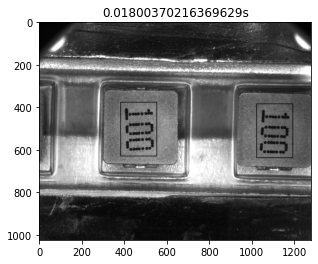

In [5]:
w, h = template.shape[::-1]
img_res = img.copy()

st = time.time()

# copys
imgs = []
imgs.append(img)

templates = []
templates.append(template)

n_subsample = 3

for i in range(n_subsample):
    imgs.append(imgs[-1][::2, ::2])
    templates.append(templates[-1][::2, ::2])

# searching
for pt in search(np.array([0, 0]), imgs[-1].shape[1], imgs[-1].shape[0], level=len(imgs)-1):
    cv2.rectangle(img_res, pt[::-1], (pt[1] + w, pt[0] + h), (0,0,255), 2)
plt.imshow(img_res, cmap='gray')
plt.title(f'{time.time() - st}s')

Text(0.5, 1.0, '0.04600954055786133s')

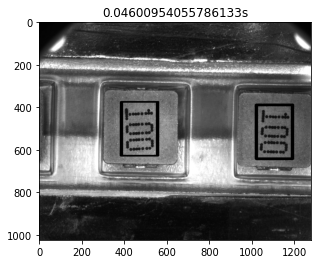

In [6]:
# openCV
w, h = template.shape[::-1]
img_res = img.copy()

st = time.time()

res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.6
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_res, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.imshow(img_res, cmap='gray')
plt.title(f'{time.time() - st}s')